- 예제를 통해 Training Loop에서 사용하는 3가지 기법을 구현해본다 ~
    - Learning Rate Warmup
    - Consine Decay
    - Gradient Clipping 

In [1]:
from importlib.metadata import version
import torch
import os
import requests

print("torch version:", version("torch"))


from previous_chapters import GPTModel
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch04 import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Device:", device)

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    text_data = response.text
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()
        
from previous_chapters import create_dataloader_v1
# Alternatively:
# from llms_from_scratch.ch02 import create_dataloader_v1


# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    text_data[:split_idx],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    text_data[split_idx:],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

torch version: 2.8.0
Device: cpu


- 이번 챕터에서 많이했던 모델 생성 + 훈련용/검증용 데이터셋 준비

### Learning Rate Warmup
- Learning Rate란?
    - 모델의 학습과정에서 가중치를 얼마나 업데이트 할건지에 대한 상수
    - Learning rate가 낮다 = 가중치 변화가 작다
- 학습 초기에는 가중치가 무작위로 초기화되어있어 Learning Rate가 높을 경우 엉뚱한 방향으로 학습될 가능성이 높아짐
- 따라서 초기에 Learning Rate를 낮추는 **Learning Rate Warmup**이 필요함

In [2]:
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01

- initial_lr = 0.0001 : 가중치가 무작위로 초기화되어있는 초기에는 시작 학습률을 낮춤
- peak_lr = 0.01 : 점진적으로 커져서 증가할 수 있는 최대 학습률

In [3]:
total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup
print(warmup_steps)

27


- 전체 훈련 데이터셋의 20%를 Learning Rate Warmup에 사용함

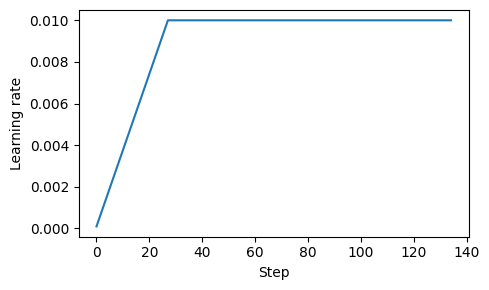

In [4]:
lr_increment = (peak_lr - initial_lr) / warmup_steps

global_step = -1
track_lrs = []

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
    
        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:
            lr = peak_lr
        
        # Apply the calculated learning rate to the optimizer
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])
    
        # Calculate loss and update weights
        # ...
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout(); plt.savefig("1.pdf")
plt.show()

```python
lr_increment = (peak_lr - initial_lr) / warmup_steps
...
if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
```
- Learning Rate를 매 step마다 lr_increment 만큼 증가시킴

### Cosine Decay
- 모델 학습 후반부에는 모델이 Loss 최저점인 학습 목표치에 도달하게됨
    - Learning Rate가 높을 경우 Loss 최저점을 지나치거나 목표 주변을 맴돌기만함 (Overshooting)
- 따라서 모델 학습이 어느정도 목표치에 도달할 경우 Learning Rate를 떨어뜨릴 필요가 있음
    - peak_lr에 도달한 후 학습이 끝날때까지 코사인 곡선을 그리며 서서히 min_lr에 가깝게 떨어뜨리는 걸 Cosine Decay라 함
    - 저자는 Linear보다 코사인 곡선이 좀 더 Learning Rate 변화가 완만하여 선호된다고 하며 실제로는 Linear를 사용하는 경우도 있다고 함


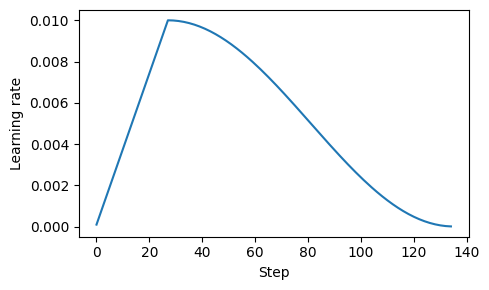

In [5]:
import math

min_lr = 0.1 * initial_lr
track_lrs = []

lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
    
        # Adjust the learning rate based on the current phase (warmup or cosine annealing)
        if global_step < warmup_steps:
            # Linear warmup
            lr = initial_lr + global_step * lr_increment  
        else:
            # Cosine annealing after warmup
            progress = ((global_step - warmup_steps) / 
                        (total_training_steps - warmup_steps))
            lr = min_lr + (peak_lr - min_lr) * 0.5 * (
                1 + math.cos(math.pi * progress))
        
        # Apply the calculated learning rate to the optimizer
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])
    
        # Calculate loss and update weights
        
plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout(); plt.savefig("2.pdf")
plt.show()

```python
if global_step < warmup_steps:
            # Linear warmup
            lr = initial_lr + global_step * lr_increment  
        else:
            # Cosine annealing after warmup
            progress = ((global_step - warmup_steps) / 
                        (total_training_steps - warmup_steps))
            lr = min_lr + (peak_lr - min_lr) * 0.5 * (
                1 + math.cos(math.pi * progress))
```
- warmup Steps 이후에 progress에 따라 코사인 곡선으로 Learning Rate가 낮아지게 됨

- 아래는 코드로 구현된 Learning Rate 코사인 곡선 하강 수식
$$LR = \text{min\_lr} + \frac{1}{2}(\text{peak\_lr} - \text{min\_lr})(1 + \cos(\pi \times \text{progress}))$$

### Gradient Clipping

- 딥러닝에서 Backpropagation 과정에서 합연산으로 인하여 기울기가 기하급수적으로 커지는 Exploding Gradient가 발생할 수 있음
    - Weight가 커질수록 학습이 정상적으로 작동하지 않거나 발산할 가능성이 커짐
- 따라서 Weight가 한도 끝도 없이 커지는걸 막기위해 제한을 걸 필요가 있음
    - Weight의 크기를 줄이 되 학습하려고 했던 방향을 유지할 수 있는 L2 Norm이 일반적으로 사용됨
-Pytorch에서는 clip_grad_norm
    - Weight Matrix의 벡터 크기를 max_norm으로 스케일링 함
- L2 Norm 연산 과정
    - 현재 Norm 측정
        - Weight가 [w1,w2,w3]라 가정할때 현재 Norm은 $\sqrt{w1^2+w2^2+w3^2}$
    - 스케일링
        - max_norm이 1.0으로 가정할때 $$\text{스케일링비율}S = \frac{\text{max\_norm}}{\text{현재 Norm}} = \frac{1.0}{\sqrt{w1^2+w2^2+w3^2}}$$
    - L2 Norm 적용
        - 현재 Weight에 도출된 스케일링 비율을 각각 곱함 $$\text{New } W = [w1 \times S, w2 \times S, w3 \times S]$$

In [6]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

def find_highest_gradient(model):
    max_grad = None
    for param in model.parameters():
        if param.grad is not None:
            grad_values = param.grad.data.flatten()
            max_grad_param = grad_values.max()
            if max_grad is None or max_grad_param > max_grad:
                max_grad = max_grad_param
    return max_grad

print("Gradient Clipping 적용 전",find_highest_gradient(model))
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
print("Gradient Clipping 적용 후",find_highest_gradient(model))



Gradient Clipping 적용 전 tensor(0.0411)
Gradient Clipping 적용 후 tensor(0.0185)


- 이제 위 내용들이 직접 적용된 train 함수를 만들어서 학습시켜보자 !

In [7]:
from previous_chapters import calc_loss_batch,calc_loss_loader,evaluate_model,generate_text_simple,generate_and_print_sample



def train_model_with_optimization(model, train_loader, val_loader, optimizer, device,
                n_epochs, eval_freq, eval_iter, start_context, tokenizer,
                warmup_steps, initial_lr=3e-05, min_lr=1e-6):

    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1

    # optimizer 초기화시 사용되는 learning rate를 가져옴
    peak_lr = optimizer.param_groups[0]["lr"]

    # 총 훈련 step 구하기
    total_training_steps = len(train_loader) * n_epochs

    # peak_lr과 인자로 들어온 initial_lr을 통해 lr_increment를 구함
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step += 1

            # Learning Rate Warmpup을 구현
            if global_step < warmup_steps:
                # Warmup Step 전까지 lr_increment만큼 점진적으로 Learning Rate 증가
                lr = initial_lr + global_step * lr_increment  
            else:
                # peak lr에 도달했을 경우 
                progress = ((global_step - warmup_steps) / 
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)  # Store the current learning rate

            
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            # warmup step 이후에는 learning rate가 peak_lr에 도달하므로 Weight가 커질것을 방지하여 Gradient clipping
            if global_step >= warmup_steps:  
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
            optimizer.step()
            tokens_seen += input_batch.numel()

            # Periodically evaluate the model on the training and validation sets
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader,
                    device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # Print the current losses
                print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        # Generate and print a sample from the model to monitor progress
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen, track_lrs


In [8]:
import tiktoken
import torch

from previous_chapters import GPTModel,train_model_simple

# Note:
# Uncomment the following code to calculate the execution time
# import time
# start_time = time.time()

torch.manual_seed(123)

## Learning Rate warmup + Gradient Clip 사용
model_with_optimization = GPTModel(GPT_CONFIG_124M)
model_with_optimization.to(device)
optimizer_new = torch.optim.AdamW(model_with_optimization.parameters(), lr=peak_lr, weight_decay=0.1)

peak_lr = 0.001
tokenizer = tiktoken.get_encoding("gpt2")
n_epochs = 15

## 모델
model_simple = GPTModel(GPT_CONFIG_124M)
model_simple.to(device)
optimizer_old = torch.optim.AdamW(model_simple.parameters(), lr=peak_lr, weight_decay=0.1)


### Warm Up + Clipping + Consine Decay X

Ep 1 (Step 000000): Train loss 9.808, Val loss 9.911
Ep 1 (Step 000005): Train loss 6.699, Val loss 7.077
Every effort moves you, to to, to to to to to to to to to to to to, to to to, to to to to to to to to to to to, to to to to to to to to to to to to to, to to to
Ep 2 (Step 000010): Train loss 6.296, Val loss 6.724
Ep 2 (Step 000015): Train loss 13.155, Val loss 14.128
Every effort moves you""                                                
Ep 3 (Step 000020): Train loss 6.188, Val loss 6.867
Ep 3 (Step 000025): Train loss 5.973, Val loss 6.799
Every effort moves you I                                                 
Ep 4 (Step 000030): Train loss 5.961, Val loss 6.784
Ep 4 (Step 000035): Train loss 5.563, Val loss 6.656
Every effort moves you.                                                 
Ep 5 (Step 000040): Train loss 5.278, Val loss 6.601
Every effort moves you I I I I I I I I I I I I I.                                    
Ep 6 (Step 000045): Train loss 5.659, Val loss 6.733
E

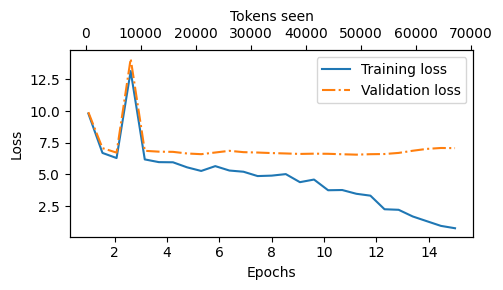

<Figure size 640x480 with 0 Axes>

In [9]:
from previous_chapters import plot_losses

train_losses, val_losses, tokens_seen= train_model_simple(
    model_simple, train_loader, val_loader, optimizer_old, device, num_epochs=n_epochs,
    eval_freq=5, eval_iter=1, start_context="Every effort moves you",
    tokenizer=tokenizer
)




epochs_tensor = torch.linspace(1, n_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
plt.tight_layout(); plt.savefig("3.pdf")
plt.show()

### Warm Up + Clipping + Cosine Decay O

Ep 1 (Iter 000000): Train loss 10.958, Val loss 10.941
Ep 1 (Iter 000005): Train loss 7.115, Val loss 6.960
Every effort moves you--------------------------------------------------
Ep 2 (Iter 000010): Train loss 6.148, Val loss 7.394
Ep 2 (Iter 000015): Train loss 6.027, Val loss 7.660
Every effort moves you""""""""""""""""""""""""""""""""""""""""""""""""""
Ep 3 (Iter 000020): Train loss 6.544, Val loss 8.498
Ep 3 (Iter 000025): Train loss 6.444, Val loss 8.692
Every effort moves you and and and and and and and to and and to and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and
Ep 4 (Iter 000030): Train loss 6.393, Val loss 8.884
Ep 4 (Iter 000035): Train loss 6.359, Val loss 8.366
Every effort moves you of of of of of of                                           of,
Ep 5 (Iter 000040): Train loss 6.929, Val loss 8.538
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

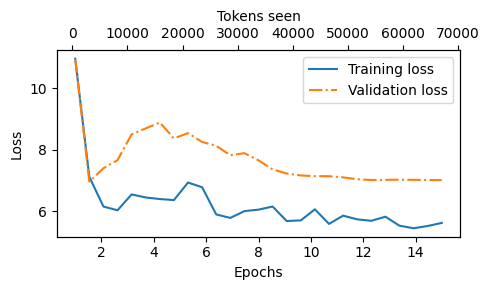

<Figure size 640x480 with 0 Axes>

In [11]:
from previous_chapters import plot_losses

train_losses, val_losses, tokens_seen, track_lrs= train_model_with_optimization(
    model_with_optimization, train_loader, val_loader, optimizer_new, device, n_epochs=n_epochs,
    eval_freq=5, eval_iter=1, start_context="Every effort moves you",
    tokenizer=tokenizer, warmup_steps=warmup_steps, 
    initial_lr=1e-5, min_lr=1e-5
)



epochs_tensor = torch.linspace(1, n_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
plt.tight_layout(); plt.savefig("4.pdf")
plt.show()